In [1]:
import pandas as pd
import torch

from config.features import ACTIVE_FEATURES
from modeling.trtg_model import TRTGModel

model = TRTGModel(features=ACTIVE_FEATURES, trgt_layers=1, aux_loss_weight=0.5, wise='feature', device='cuda:0')
model.load_weights(r'D:\codes\www\checkpoints\xiaorong\wm\wm_trgt_1_layer_auxloss0.5_active_th_seed_42\5.pth', strict=True)

2024-10-12 17:39:34,147 - trtg_model.py - INFO - base model info: {'hidden_dim': 172, 'params': {'Total': 422936, 'Trainable': 422936}, 'device': 'cuda:0'}
D:\codes\www\modeling\trtg_model.py:220: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

In [1]:
from modeling.base_model import BaseModel
import pandas as pd
import torch

from config.features import ACTIVE_FEATURES
from modeling.trtg_model import TRTGModel

model = BaseModel(features=ACTIVE_FEATURES, device='cuda:0', cross_net='DNN')
model.load_weights(r'D:\codes\www\checkpoints\wxsh\wxsh_DNN_active_th_seed_42\3.pth', strict=True)

2024-10-14 21:19:55,660 - base_model.py - INFO - base model info: {'hidden_dim': 172, 'params': {'Total': 388209, 'Trainable': 388209}, 'device': 'cuda:0'}
D:\codes\www\modeling\base_model.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

In [2]:
from torch.utils.data import DataLoader
from utils.datasets import MultiLabelDataset, multi_label_collate

val_dataset = MultiLabelDataset('wxsh', 826, 829, features=ACTIVE_FEATURES, max_rows=None, minus_label_col=None)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=True, collate_fn=multi_label_collate)

D:\codes\www\utils\common.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  new_df = pd.read_csv(csv_file, usecols=columns, sep=sep)
2024-10-14 21:21:51,012 - common.py - INFO - Read dataframe from csv D:/codes/www\processed_data\wxsh/wxsh_6h_826.csv | sample number: 20826
2024-10-14 21:21:51,184 - common.py - INFO - Read dataframe from csv D:/codes/www\processed_data\wxsh/wxsh_6h_827.csv | sample number: 18341
2024-10-14 21:21:51,341 - common.py - INFO - Read dataframe from csv D:/codes/www\processed_data\wxsh/wxsh_6h_828.csv | sample number: 20107
2024-10-14 21:21:51,521 - common.py - INFO - Read dataframe from csv D:/codes/www\processed_data\wxsh/wxsh_6h_829.csv | sample number: 18743
2024-10-14 21:21:51,553 - common.py - INFO - sample num: 78017


In [3]:
from tqdm.auto import tqdm
gate_outputs = []
cls_labels = []
trgt_outputs = []
true_label = []
p = []
v = []
model.eval()
for batch in tqdm(val_loader):
    true_label += batch[2]['ltv3'].tolist()
    o = model(batch)
    go = o['gat_outputs'][0].detach().cpu().numpy()
    gate_outputs.append(go)
    cls_labels += o['cls_labels'].detach().cpu().tolist()
    trgt_outputs.append(o['trgt_output'].detach().cpu().numpy())
    p += o['prediction_p'].detach().cpu().tolist()
    v += o['prediction_v'].detach().cpu().tolist()

  0%|          | 0/77 [00:00<?, ?it/s]

IndexError: too many indices for tensor of dimension 1

In [4]:
df = pd.DataFrame({'Predicted payment probability by TRGT':p , 'Payment predicted by TRGT':v, 'Types of customers predicted by TRGT': cls_labels, 'true_label': true_label})

In [5]:
df['Types of customers predicted by TRGT'] = df['Types of customers predicted by TRGT'].apply(lambda x : 2 if x == 1 else x)
df = df[df['Types of customers predicted by TRGT'] != 0]
df = df[df['true_label'] != 0]

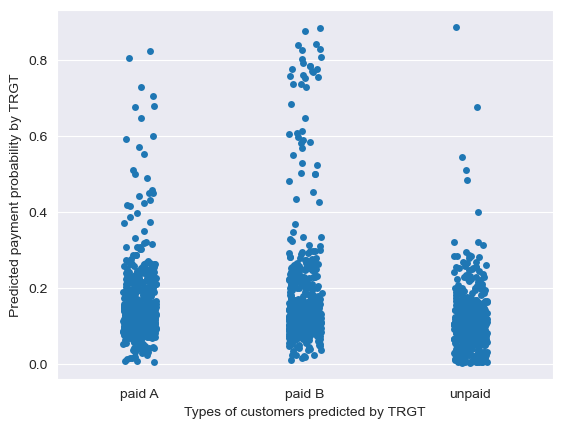

In [24]:
from math import log
df = pd.DataFrame({'Predicted payment probability by TRGT':p , 'Payment predicted by TRGT':v, 'Types of customers predicted by TRGT': cls_labels, 'true_label': true_label})
df['Types of customers predicted by TRGT'] = df['Types of customers predicted by TRGT'].apply(lambda x : 2 if x == 1 else x)
# df = df[df['Types of customers predicted by TRGT'] != 0]
m = {
    0: 'unpaid',
    2: 'paid A',
    3: 'paid B'
}
df['Types of customers predicted by TRGT'] = df['Types of customers predicted by TRGT'].apply(lambda x : m[x])
df = df[df['Types of customers predicted by TRGT'] != 0]
df = df.groupby('Types of customers predicted by TRGT').sample(500, random_state=42)
import seaborn as sns
fig = sns.stripplot(x="Types of customers predicted by TRGT", y="Predicted payment probability by TRGT", data=df).get_figure()

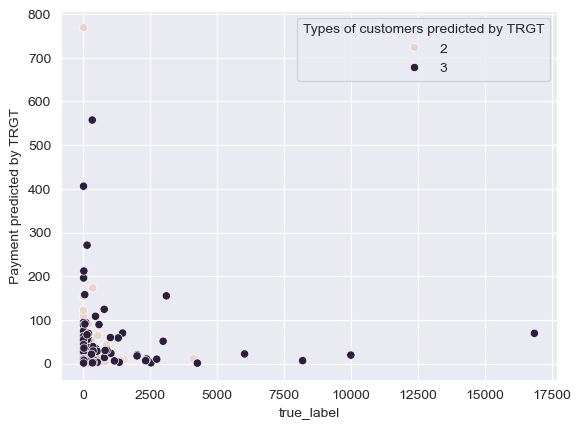

In [22]:
from math import log
import seaborn as sns
sdf = df.groupby('Types of customers predicted by TRGT').sample(500, random_state=4123)
# sdf['Payment predicted by TRGT'] = sdf['Payment predicted by TRGT'].apply(log)
# sdf['true_label'] = sdf['true_label'].apply(lambda x : log(x))
fig = sns.scatterplot(x='true_label', y='Payment predicted by TRGT', hue='Types of customers predicted by TRGT', data=sdf).get_figure()

In [99]:
fig.savefig('./test.png', dpi=600)

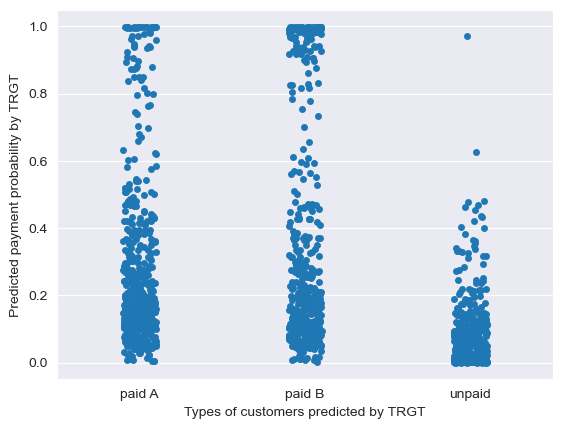

In [64]:
fig.savefig('./wxsh_payment_none.png', dpi=600)

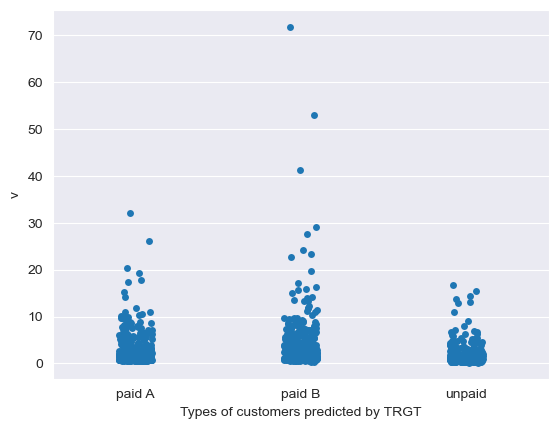

In [60]:
fig = sns.stripplot(x="Types of customers predicted by TRGT", y="v", data=df).get_figure()

In [7]:

# df = df[df['true_label'] > 0.]

In [21]:
df

,p,v,cls_labels,true_label
45615,0.084296,2.533489,2,30.0
54426,0.114429,3.789596,2,196.0
66670,0.033158,1.388814,2,68.0
67415,0.030349,0.963190,2,60.0
32417,0.097783,1.692625,2,30.0
...,...,...,...,...
63673,0.125410,2.182986,3,30.0
39124,0.031967,1.431318,3,792.0
16884,0.100190,3.734429,3,228.0
52702,0.125022,4.748563,3,74.0


In [22]:
import matplotlib.pyplot as plt

In [23]:
df

,p,v,cls_labels,true_label
45615,0.084296,2.533489,2,30.0
54426,0.114429,3.789596,2,196.0
66670,0.033158,1.388814,2,68.0
67415,0.030349,0.963190,2,60.0
32417,0.097783,1.692625,2,30.0
...,...,...,...,...
63673,0.125410,2.182986,3,30.0
39124,0.031967,1.431318,3,792.0
16884,0.100190,3.734429,3,228.0
52702,0.125022,4.748563,3,74.0


In [24]:
df['cls_labels'].value_counts()

cls_labels
2    1000
3    1000
Name: count, dtype: int64

In [25]:
df['cls_labels'].value_counts()

cls_labels
2    1000
3    1000
Name: count, dtype: int64

2024-10-12 11:20:43,844 - category.py - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-12 11:20:43,850 - category.py - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


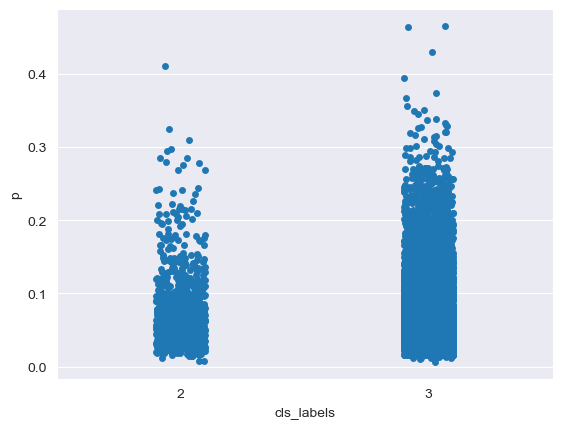

In [57]:
df['cls_labels'].value_counts()

cls_labels
2    1000
3    1000
Name: count, dtype: int64

In [35]:
plt.savefig('./visual.png')

<Figure size 640x480 with 0 Axes>

In [58]:
from math import log

df['v'] = df['v'].apply(lambda x : log(x))

2024-10-12 11:05:57,024 - category.py - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-12 11:05:57,029 - category.py - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='cls_labels', ylabel='v'>

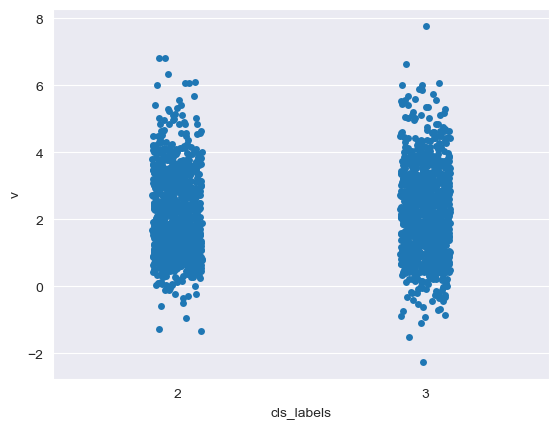

In [59]:
sns.stripplot(x="cls_labels", y="v", data=df)

In [9]:
import numpy as np
np.mean(p)

0.046056833

In [4]:
import numpy as np

gates = np.concatenate(gate_outputs, axis=0)
cls = np.concatenate(cls_labels, axis=0)
trgt_outputs = np.concatenate(trgt_outputs, axis=0)

In [5]:
import pandas as pd
df = pd.DataFrame(np.concatenate([np.expand_dims(cls, 1), trgt_outputs], axis=1))

In [6]:
pay_df = df[df[0]>0.0]

In [7]:
pay_df.iloc[:, 0] = pay_df.iloc[:, 0].apply(lambda x: 2. if x==1. else x)

In [8]:
emb = np.array(pay_df.iloc[:, 1:])
c = np.array(pay_df.iloc[:, 0])

In [9]:
import hypertools as hyp
hyp.plot(emb,'.',reduce='TSNE',ndims=2,hue=c,palette=['#F05A7E', '#125B9A'])

D:\app\miniconda3\Lib\site-packages\hypertools\plot\plot.py:510: UserWarning: Could not convert all list arguments to numpy arrays.  If list is longer than 256 items, it will automatically be pickled, which could cause Python 2/3 compatibility issues for the DataGeometry object.
  warnings.warn('Could not convert all list arguments to numpy '


In [10]:
import matplotlib.pyplot as plt

In [11]:
plt.savefig(r'./visualize_mdnf.png', dpi=600)

(102843, 44)

In [12]:
cls.squeeze().shape

(102843,)

In [14]:
np.expand_dims(cls, 1).shape

(102843, 1)

C:\Users\hhaotian\AppData\Local\Temp\ipykernel_32944\1058782110.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfa = pay_df[df[43]<3.0]
C:\Users\hhaotian\AppData\Local\Temp\ipykernel_32944\1058782110.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfb = pay_df[df[43]==3.0]


In [37]:
dfa.shape

(6106, 44)

In [38]:
dfb.shape

(6323, 44)

In [66]:
import torch
ma = torch.mean(torch.sigmoid(torch.tensor(np.array(dfa))), dim=0)
ma.shape

torch.Size([44])

In [67]:
import torch
mb = torch.mean(torch.sigmoid(torch.tensor(np.array(dfb))), dim=0)
mb.shape

torch.Size([44])

In [54]:
ma

tensor([0.2311, 0.3654, 0.2033, 0.3533, 0.3550, 0.6133, 0.4823, 0.1398, 0.1407,
        0.3576, 0.5140, 0.6575, 0.2935, 0.2761, 0.6834, 0.3532, 0.2888, 0.3141,
        0.2527, 0.8219, 0.3651, 0.1840, 0.0809, 0.1849, 0.3587, 0.2125, 0.4605,
        0.2526, 0.2344, 0.4751, 0.3736, 0.4373, 0.4308, 0.3605, 0.1775, 0.5041,
        0.4407, 0.2427, 0.9069, 0.2910, 0.5607, 0.4575, 0.8091, 0.9526],
       dtype=torch.float64)

In [56]:
x = list(range(ma.shape[0]))

In [59]:
import matplotlib.pyplot as plt

# 创建折线图
plt.plot(x, ma.tolist())

# 添加标题和轴标签
plt.title("简单折线图")
plt.xlabel("X轴")
plt.ylabel("Y轴")

# 显示图形
plt.show()
plt.savefig('./feature_importance.png', dpi=600)

<Figure size 640x480 with 1 Axes>

In [68]:
sdf = pd.DataFrame([ma.tolist(), mb.tolist()])

In [69]:
sdf.T.to_csv('importance.csv')